# Bitcoin Forecasting

This notebook was created by Camille-Amaury JUGE, with the purpose to learn deep learning and tensorflow/keras on the bitcoin historical data following the data.world's dataset : 

https://data.world/amodu/bitcoin-price-analysis. 

The aim is to focus even more on Recurrent Neural Nework.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
# scikit-learn
from sklearn.model_selection import train_test_split

rcParams['figure.figsize'] = 16,10

## Preprocessing

In [26]:
df = pd.read_csv("Bittrex_BTCUSD_d.csv", header=1)
df = df.sort_index(axis=0, ascending=False)
df.head(10)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
1713,1.449878e+09,2015-12-12,BTCUSD,420.0,420.0,420.0,420.0,0.000304,0.127600
1712,1.449965e+09,2015-12-13,BTCUSD,420.0,420.0,420.0,420.0,0.000000,0.000000
1711,1.450051e+09,2015-12-14,BTCUSD,420.0,420.0,420.0,420.0,0.000000,0.000000
1710,1.450138e+09,2015-12-15,BTCUSD,420.0,450.0,420.0,450.0,0.401500,180.090000
1709,1.450224e+09,2015-12-16,BTCUSD,450.0,470.0,450.0,451.0,0.074270,34.140000
1708,1.450310e+09,2015-12-17,BTCUSD,451.0,451.0,451.0,451.0,0.000000,0.000000
1707,1.450397e+09,2015-12-18,BTCUSD,459.0,459.0,459.0,459.0,0.000012,0.005421
1706,1.450483e+09,2015-12-19,BTCUSD,459.0,459.0,451.0,451.0,0.010200,4.600000
1705,1.450570e+09,2015-12-20,BTCUSD,450.0,450.0,450.0,450.0,0.013920,6.260000
1704,1.450656e+09,2015-12-21,BTCUSD,450.0,450.0,450.0,450.0,0.000000,0.000000


In [28]:
df[df.columns[3:9]] = df[df.columns[3:9]].astype(np.float32)
df.dtypes

Unix Timestamp    float64
Date               object
Symbol             object
Open              float32
High              float32
Low               float32
Close             float32
Volume BTC        float32
Volume USD        float32
dtype: object

We will check if there is no NAN values that we won't be able to handle

In [29]:
df.isna().sum()

Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume BTC        0
Volume USD        0
dtype: int64

In [31]:
df.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
Unix Timestamp,1714.0,1.524195e+09,43142855.0,1.449878e+09,1.486879e+09,1.523880e+09,1.561918e+09,1.598918e+09
Open,1714.0,5.373000e+03,3963.0,3.600000e+02,1.018000e+03,5.886000e+03,8.599000e+03,1.926100e+04
High,1714.0,5.527000e+03,4095.0,3.650000e+02,1.040000e+03,6.179000e+03,8.816000e+03,1.985000e+04
Low,1714.0,5.194000e+03,3795.0,3.260000e+02,9.920000e+02,5.667000e+03,8.298000e+03,1.853800e+04
Close,1714.0,5.380000e+03,3964.0,3.650000e+02,1.015000e+03,5.925000e+03,8.613000e+03,1.926100e+04
Volume BTC,1714.0,1.507000e+03,2913.0,0.000000e+00,2.000000e+00,5.140000e+02,1.409000e+03,4.061800e+04
Volume USD,1714.0,1.166965e+07,26151006.0,0.000000e+00,1.575000e+03,3.327371e+06,1.003088e+07,3.330574e+08


Since we have a small dataset of 2000 rows, we don't expect Neural Networks to perform as they could with a lot more data.

In [32]:
def createXY(df, test_proportion=0.1, value_columns=[], Y=[], day_range=1):
    # create columns
    columns = []
    columns_val = []
    for i in range(day_range,0,-1):
        columns += [(value_columns[j]+"-{}".format(i)) for j in range(len(value_columns))]
    for j in range(len(columns)):
        columns_val.append([])
    
    indexes = list(df.index)
    indexes = indexes[day_range:]
    for i in indexes:
        for col in range(len(value_columns)):
            for j in range(day_range,0,-1):
                columns_val[len(value_columns)*(day_range-j)+col].append(df.loc[i-j, columns[col].split("-")[0]])
    # X's
    data = pd.DataFrame(columns_val).transpose()
    limit = int(len(data)*(1-test_proportion))
    X_train = data.iloc[:limit].values
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = data.iloc[limit:].values
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))
    # Y's
    target = df[Y].iloc[day_range:]
    Y_train = target.iloc[:limit].values
    Y_test = target.iloc[limit:].values
    return X_train, Y_train, X_test, Y_test

In [7]:
x1, y1, x2, y2 = createXY(df, value_columns=["Open", "Close"], Y=["Open", "Close"], day_range=10)
y2.shape

(45, 1)

## Simple Neural Network

In this part we will try to explore the simple to more complex neural network

### Single hidden layer

This model will be the simplier we will be using. We choose the rectified linear unit (reLU) function, since it is quite better for backpropagation and non-linear behavior, applied on the 10 hidden neurons layer.

Then our output layer will be a 10 neurons using the softmax function in order to represents the 10 classes vector with the predicted class.

Lastly, we will be using the categorical crossentropy regarding to our problem, the optimizer could have been "rmsprop" rather than "adam", but here we don't mind. Our comparaison metric will be the accuracy to predict a class.

In [8]:
model = Sequential()
model.add(Dense(20, input_shape=(1,x1.shape[2]), activation="relu"))
model.add(Dense(4))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsoluteError()])

In [9]:
model.fit(x1, y1, epochs=100, validation_split=0.1)

Train on 357 samples, validate on 40 samples
Epoch 1/100
357/357 [==============================] - 1s 3ms/sample - loss: 4757.0677 - mean_absolute_error: 4622.9878 - val_loss: 7028.5479 - val_mean_absolute_error: 6365.6855
Epoch 2/100
357/357 [==============================] - 0s 88us/sample - loss: 1157.8178 - mean_absolute_error: 1099.9520 - val_loss: 2753.4801 - val_mean_absolute_error: 2516.3748
Epoch 3/100
357/357 [==============================] - 0s 73us/sample - loss: 606.7502 - mean_absolute_error: 582.6739 - val_loss: 1959.8440 - val_mean_absolute_error: 1820.7177
Epoch 4/100
357/357 [==============================] - 0s 73us/sample - loss: 404.9205 - mean_absolute_error: 401.3828 - val_loss: 1256.4450 - val_mean_absolute_error: 1168.8297
Epoch 5/100
357/357 [==============================] - 0s 73us/sample - loss: 380.9170 - mean_absolute_error: 366.2133 - val_loss: 1937.9224 - val_mean_absolute_error: 1791.1521
Epoch 6/100
357/357 [==============================] - 0s 71us

Epoch 47/100
357/357 [==============================] - 0s 71us/sample - loss: 213.1794 - mean_absolute_error: 214.4222 - val_loss: 920.7032 - val_mean_absolute_error: 792.5490
Epoch 48/100
357/357 [==============================] - 0s 74us/sample - loss: 228.3461 - mean_absolute_error: 220.3244 - val_loss: 1171.8756 - val_mean_absolute_error: 1001.4781
Epoch 49/100
357/357 [==============================] - 0s 71us/sample - loss: 242.0707 - mean_absolute_error: 226.1811 - val_loss: 973.6113 - val_mean_absolute_error: 836.8568
Epoch 50/100
357/357 [==============================] - 0s 71us/sample - loss: 208.0022 - mean_absolute_error: 202.7377 - val_loss: 889.6608 - val_mean_absolute_error: 778.0876
Epoch 51/100
357/357 [==============================] - 0s 73us/sample - loss: 214.0284 - mean_absolute_error: 203.8159 - val_loss: 871.1490 - val_mean_absolute_error: 781.5771
Epoch 52/100
357/357 [==============================] - 0s 73us/sample - loss: 222.9764 - mean_absolute_error: 21

357/357 [==============================] - 0s 73us/sample - loss: 219.4941 - mean_absolute_error: 214.2374 - val_loss: 890.2596 - val_mean_absolute_error: 770.2148
Epoch 94/100
357/357 [==============================] - 0s 73us/sample - loss: 185.1128 - mean_absolute_error: 184.4443 - val_loss: 797.5333 - val_mean_absolute_error: 701.4822
Epoch 95/100
357/357 [==============================] - 0s 70us/sample - loss: 204.8793 - mean_absolute_error: 213.1656 - val_loss: 738.0034 - val_mean_absolute_error: 662.3373
Epoch 96/100
357/357 [==============================] - 0s 69us/sample - loss: 205.8354 - mean_absolute_error: 211.0661 - val_loss: 726.8916 - val_mean_absolute_error: 654.8478
Epoch 97/100
357/357 [==============================] - 0s 71us/sample - loss: 187.0612 - mean_absolute_error: 184.9843 - val_loss: 726.7361 - val_mean_absolute_error: 654.9353
Epoch 98/100
357/357 [==============================] - 0s 73us/sample - loss: 217.2707 - mean_absolute_error: 207.2700 - val_lo

In [10]:
_, test_acc = model.evaluate(x2, y2)
print(test_acc)

45/45 [==============================] - 0s 122us/sample - loss: 450.6842 - mean_absolute_error: 421.7300
421.73004


In [11]:
y_predicted = model.predict(x2, verbose=0)
y_predicted.shape
print("{} / {}".format(y_predicted[0], y2[0]))

[[8430.433]] / [8662.8]


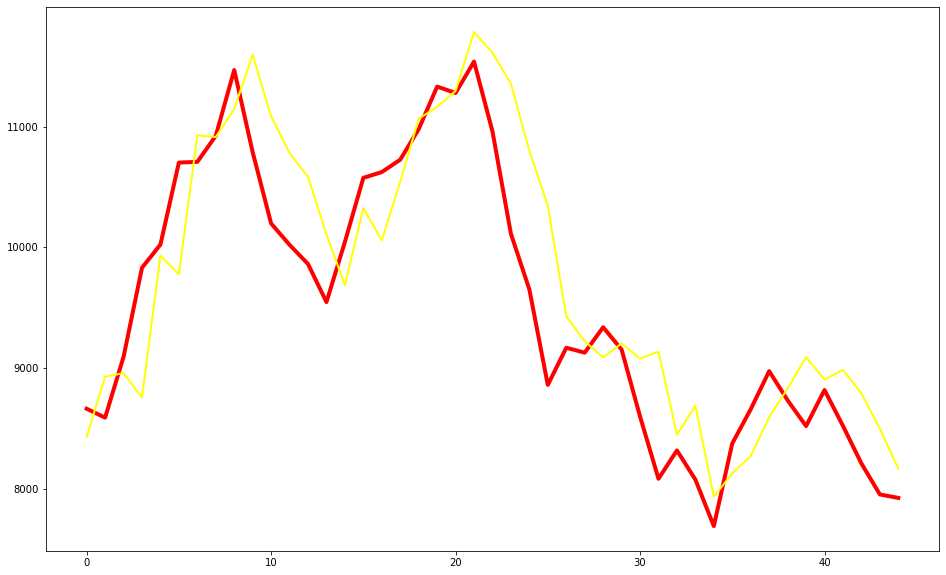

In [12]:
plt.plot(range(0,45),np.reshape(y2, (len(y2))), color='red', linewidth=4, label="Actual")
plt.plot(range(0,45),np.reshape(y_predicted, (len(y_predicted))), color='yellow', linewidth=2, label="Predicted")

## Recurrent Neural Network

In this part we will try to explore the Recurrent Neural Network

In [13]:
model1 = Sequential()
model1.add(SimpleRNN(20, return_sequences=True,input_shape=(1,x1.shape[2]), activation="relu"))
model1.add(Dense(5))
model1.add(Dense(1))
model1.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsoluteError()])

In [14]:
model1.fit(x1, y1, epochs=100, validation_split=0.1)

Train on 357 samples, validate on 40 samples
Epoch 1/100
357/357 [==============================] - 2s 5ms/sample - loss: 2462.9221 - mean_absolute_error: 2346.1235 - val_loss: 1092.6900 - val_mean_absolute_error: 1000.6761
Epoch 2/100
357/357 [==============================] - 0s 81us/sample - loss: 681.2868 - mean_absolute_error: 640.9163 - val_loss: 1423.2888 - val_mean_absolute_error: 1283.9877
Epoch 3/100
357/357 [==============================] - 0s 85us/sample - loss: 343.9395 - mean_absolute_error: 326.4445 - val_loss: 1247.8463 - val_mean_absolute_error: 1128.3795
Epoch 4/100
357/357 [==============================] - 0s 83us/sample - loss: 296.7695 - mean_absolute_error: 312.2513 - val_loss: 1023.2981 - val_mean_absolute_error: 955.5663
Epoch 5/100
357/357 [==============================] - 0s 83us/sample - loss: 279.4158 - mean_absolute_error: 296.0416 - val_loss: 1053.1707 - val_mean_absolute_error: 969.6513
Epoch 6/100
357/357 [==============================] - 0s 87us/sam

Epoch 47/100
357/357 [==============================] - 0s 90us/sample - loss: 185.5186 - mean_absolute_error: 183.8525 - val_loss: 908.1862 - val_mean_absolute_error: 857.8311
Epoch 48/100
357/357 [==============================] - 0s 85us/sample - loss: 208.6793 - mean_absolute_error: 199.1435 - val_loss: 981.4579 - val_mean_absolute_error: 912.1832
Epoch 49/100
357/357 [==============================] - 0s 83us/sample - loss: 205.0031 - mean_absolute_error: 221.5627 - val_loss: 977.1646 - val_mean_absolute_error: 908.7656
Epoch 50/100
357/357 [==============================] - 0s 88us/sample - loss: 188.3127 - mean_absolute_error: 180.4303 - val_loss: 732.9117 - val_mean_absolute_error: 713.8546
Epoch 51/100
357/357 [==============================] - 0s 90us/sample - loss: 167.6398 - mean_absolute_error: 161.0563 - val_loss: 869.5321 - val_mean_absolute_error: 826.6400
Epoch 52/100
357/357 [==============================] - 0s 88us/sample - loss: 176.3283 - mean_absolute_error: 170.

357/357 [==============================] - 0s 87us/sample - loss: 182.4417 - mean_absolute_error: 174.3420 - val_loss: 692.6243 - val_mean_absolute_error: 674.9531
Epoch 94/100
357/357 [==============================] - 0s 87us/sample - loss: 166.3528 - mean_absolute_error: 160.7056 - val_loss: 690.1785 - val_mean_absolute_error: 673.5957
Epoch 95/100
357/357 [==============================] - 0s 80us/sample - loss: 158.7428 - mean_absolute_error: 153.5604 - val_loss: 718.4778 - val_mean_absolute_error: 702.2188
Epoch 96/100
357/357 [==============================] - 0s 83us/sample - loss: 176.0867 - mean_absolute_error: 168.0586 - val_loss: 760.5849 - val_mean_absolute_error: 737.8950
Epoch 97/100
357/357 [==============================] - 0s 84us/sample - loss: 159.0908 - mean_absolute_error: 152.9085 - val_loss: 693.5892 - val_mean_absolute_error: 677.9086
Epoch 98/100
357/357 [==============================] - 0s 85us/sample - loss: 166.3226 - mean_absolute_error: 176.4953 - val_lo

In [15]:
_, test_acc = model1.evaluate(x2, y2)
print(test_acc)

45/45 [==============================] - 0s 111us/sample - loss: 350.8190 - mean_absolute_error: 312.6074
312.60742


In [16]:
y_predicted = model1.predict(x2, verbose=0)
y_predicted.shape
print("{} / {}".format(y_predicted[0], y2[0]))

[[7860.5024]] / [8662.8]


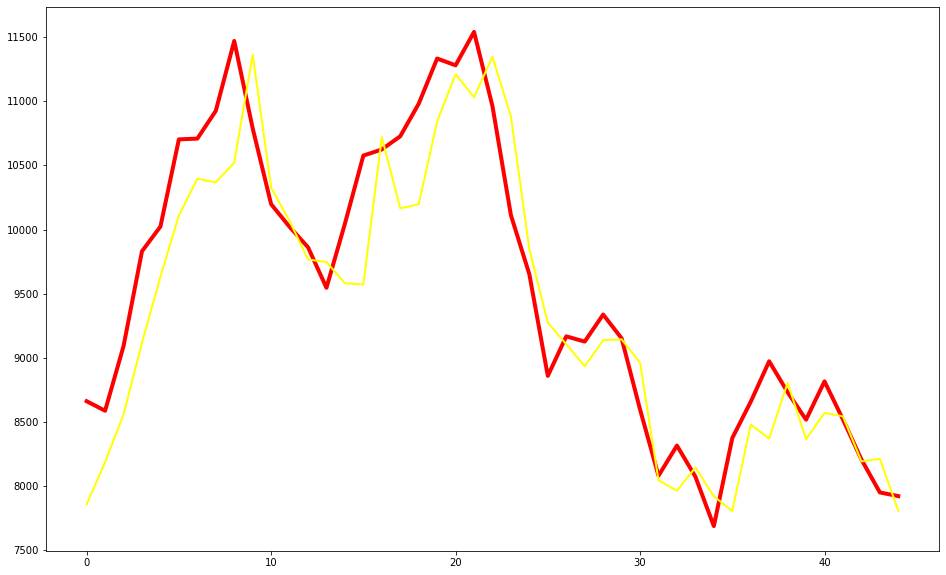

In [17]:
plt.plot(range(0,45),np.reshape(y2, (len(y2))), color='red', linewidth=4, label="Actual")
plt.plot(range(0,45),np.reshape(y_predicted, (len(y_predicted))), color='yellow', linewidth=2, label="Predicted")

In [18]:
model2 = Sequential()
model2.add(LSTM(20, return_sequences=True,input_shape=(1,x1.shape[2]), activation="relu"))
model2.add(Dense(5))
model2.add(Dense(1))
model2.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer='adam', metrics=[tf.keras.losses.MeanAbsoluteError()])

In [19]:
model2.fit(x1, y1, epochs=100, validation_split=0.1)

Train on 357 samples, validate on 40 samples
Epoch 1/100
357/357 [==============================] - 2s 6ms/sample - loss: 3832.1302 - mean_absolute_error: 3756.9963 - val_loss: 8074.3139 - val_mean_absolute_error: 6992.6592
Epoch 2/100
357/357 [==============================] - 0s 90us/sample - loss: 2605.5297 - mean_absolute_error: 2620.6377 - val_loss: 4912.6933 - val_mean_absolute_error: 4131.9712
Epoch 3/100
357/357 [==============================] - 0s 85us/sample - loss: 1672.6054 - mean_absolute_error: 1606.7788 - val_loss: 1734.4681 - val_mean_absolute_error: 1402.7859
Epoch 4/100
357/357 [==============================] - 0s 88us/sample - loss: 646.1127 - mean_absolute_error: 640.9383 - val_loss: 2274.1776 - val_mean_absolute_error: 2388.6667
Epoch 5/100
357/357 [==============================] - 0s 90us/sample - loss: 496.1736 - mean_absolute_error: 478.8640 - val_loss: 2815.2015 - val_mean_absolute_error: 2880.6311
Epoch 6/100
357/357 [==============================] - 0s 87

357/357 [==============================] - 0s 94us/sample - loss: 308.7838 - mean_absolute_error: 333.8676 - val_loss: 1376.3479 - val_mean_absolute_error: 1362.6157
Epoch 47/100
357/357 [==============================] - 0s 91us/sample - loss: 292.8573 - mean_absolute_error: 280.7475 - val_loss: 1340.6305 - val_mean_absolute_error: 1323.2236
Epoch 48/100
357/357 [==============================] - 0s 85us/sample - loss: 297.7979 - mean_absolute_error: 335.6896 - val_loss: 1213.3088 - val_mean_absolute_error: 1189.1448
Epoch 49/100
357/357 [==============================] - 0s 88us/sample - loss: 294.6406 - mean_absolute_error: 279.6108 - val_loss: 1365.3950 - val_mean_absolute_error: 1339.8090
Epoch 50/100
357/357 [==============================] - 0s 90us/sample - loss: 285.9381 - mean_absolute_error: 275.5129 - val_loss: 1258.6134 - val_mean_absolute_error: 1230.6565
Epoch 51/100
357/357 [==============================] - 0s 88us/sample - loss: 284.7993 - mean_absolute_error: 268.306

Epoch 92/100
357/357 [==============================] - 0s 94us/sample - loss: 236.9145 - mean_absolute_error: 225.3148 - val_loss: 950.2220 - val_mean_absolute_error: 841.1056
Epoch 93/100
357/357 [==============================] - 0s 95us/sample - loss: 228.6444 - mean_absolute_error: 244.3748 - val_loss: 1077.3935 - val_mean_absolute_error: 944.7104
Epoch 94/100
357/357 [==============================] - 0s 97us/sample - loss: 231.6491 - mean_absolute_error: 222.0719 - val_loss: 940.8166 - val_mean_absolute_error: 833.3949
Epoch 95/100
357/357 [==============================] - 0s 90us/sample - loss: 230.0678 - mean_absolute_error: 233.3607 - val_loss: 1125.1052 - val_mean_absolute_error: 984.8456
Epoch 96/100
357/357 [==============================] - 0s 95us/sample - loss: 234.4659 - mean_absolute_error: 226.2134 - val_loss: 914.8423 - val_mean_absolute_error: 812.0559
Epoch 97/100
357/357 [==============================] - 0s 92us/sample - loss: 229.5377 - mean_absolute_error: 25

In [20]:
_, test_acc = model2.evaluate(x2, y2)
print(test_acc)

45/45 [==============================] - 0s 111us/sample - loss: 485.6928 - mean_absolute_error: 454.3432
454.3432


In [21]:
y_predicted = model2.predict(x2, verbose=0)
y_predicted.shape
print("{} / {}".format(y_predicted[0], y2[0]))

[[9014.863]] / [8662.8]


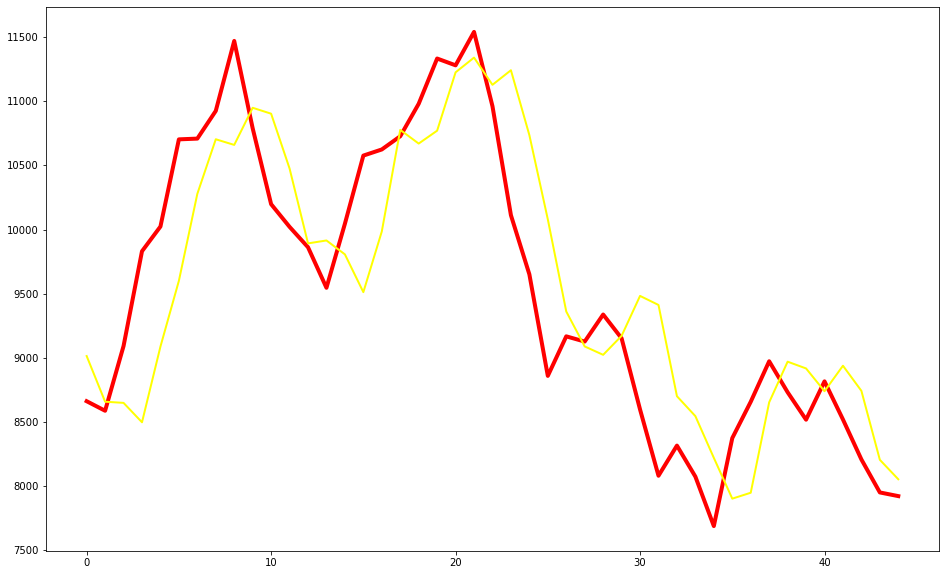

In [22]:
plt.plot(range(0,45),np.reshape(y2, (len(y2))), color='red', linewidth=4, label="Actual")
plt.plot(range(0,45),np.reshape(y_predicted, (len(y_predicted))), color='yellow', linewidth=2, label="Predicted")